<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 60
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 3
    
args = Parser()
torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': False}

<b>Download MNIST Data using torchvision datasets module</b>

In [3]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        params1 = self.state_dict()
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
        
                    
        self.load_state_dict(params1, strict=False)
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
        
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            self.load_state_dict(params1, strict=False)
        
    

In [5]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [6]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,1,3
1,2,3
2,1,2


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [7]:
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], tuple):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = tuple(reversed(target_worker_split[target_value]))
        else:
            current_worker_idx = target_worker_split[target.item()]
        
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            input_data = torch.cat(input_data)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
            
        
        target_worker_dataset[current_worker_idx].append((data, target))
            
        
    models = [Net() for _ in range(args.num_of_workers)]
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [8]:
def update(data, target, model, optimizer):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    return model

In [9]:
def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = worker1_model.state_dict()
    worker2_params = worker2_model.state_dict()
    
    #Send worker2 params to worker1 for averaging at worker1
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    
    #Send worker1 params to worker2 for averaging at worker2
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    current_worker_idx = data_index % len(compute_nodes)
    worker1_model = models[current_worker_idx]
    worker1_params = worker1_model.state_dict().copy()
    idx = 0
    other_worker_params = []
    for node in compute_nodes:
        if idx != current_worker_idx:
            neighbour_model = models[idx]
            neighbour_model_params = neighbour_model.state_dict().copy()
            other_worker_params.append(neighbour_model_params)
        idx += 1
    
    worker1_model.federated_avg_multi(other_worker_params, compute_nodes[current_worker_idx])
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [10]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, exchange=False):
    
    if federated_average:
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
        
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    

    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        
    #Exchange of parameter between two remote models.
    if exchange:
        #exchange_parameters(models, epoch_id)
        exchange_parameters_multiple(models, epoch_id)
  
        
    for model in models:
        model.get()
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [11]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [12]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if exchange:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [13]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-02-27 14:11:35.323120
Epoch Number 1
Test set for worker worker-0: Average loss: 8.0698 & Average Accuracy : 0.2969
Test set for worker worker-1: Average loss: 8.5712 & Average Accuracy : 0.2907
Test set for worker worker-2: Average loss: 6.4508 & Average Accuracy : 0.3825
Communication time over the network 94.92 s

Epoch Number 2
Test set for worker worker-0: Average loss: 8.5670 & Average Accuracy : 0.2984
Test set for worker worker-1: Average loss: 9.2313 & Average Accuracy : 0.2940
Test set for worker worker-2: Average loss: 6.5208 & Average Accuracy : 0.3871
Communication time over the network 84.07 s

Epoch Number 3
Test set for worker worker-0: Average loss: 8.7468 & Average Accuracy : 0.2988
Test set for worker worker-1: Average loss: 9.4259 & Average Accuracy : 0.2948
Test set for worker worker-2: Average loss: 6.5030 & Average Accuracy : 0.3900
Communication time over the network 91.84 s

Epoch Number 4
Test set for worker worker-0: Average loss: 8.8464 & Ave

Test set for worker worker-2: Average loss: 7.9940 & Average Accuracy : 0.3960
Communication time over the network 89.3 s

Epoch Number 29
Test set for worker worker-0: Average loss: 10.4898 & Average Accuracy : 0.3010
Test set for worker worker-1: Average loss: 11.0107 & Average Accuracy : 0.2983
Test set for worker worker-2: Average loss: 8.0516 & Average Accuracy : 0.3961
Communication time over the network 87.64 s

Epoch Number 30
Test set for worker worker-0: Average loss: 10.5545 & Average Accuracy : 0.3010
Test set for worker worker-1: Average loss: 11.0858 & Average Accuracy : 0.2983
Test set for worker worker-2: Average loss: 8.1042 & Average Accuracy : 0.3961
Communication time over the network 90.74 s

Epoch Number 31
Test set for worker worker-0: Average loss: 10.6250 & Average Accuracy : 0.3010
Test set for worker worker-1: Average loss: 11.1623 & Average Accuracy : 0.2984
Test set for worker worker-2: Average loss: 8.1739 & Average Accuracy : 0.3961
Communication time ove

Test set for worker worker-0: Average loss: 12.3586 & Average Accuracy : 0.3011
Test set for worker worker-1: Average loss: 12.5225 & Average Accuracy : 0.2992
Test set for worker worker-2: Average loss: 9.5787 & Average Accuracy : 0.3962
Communication time over the network 115.06 s

Epoch Number 57
Test set for worker worker-0: Average loss: 12.4324 & Average Accuracy : 0.3011
Test set for worker worker-1: Average loss: 12.5704 & Average Accuracy : 0.2992
Test set for worker worker-2: Average loss: 9.6335 & Average Accuracy : 0.3962
Communication time over the network 113.33 s

Epoch Number 58
Test set for worker worker-0: Average loss: 12.5050 & Average Accuracy : 0.3011
Test set for worker worker-1: Average loss: 12.6146 & Average Accuracy : 0.2992
Test set for worker worker-2: Average loss: 9.6779 & Average Accuracy : 0.3961
Communication time over the network 115.01 s

Epoch Number 59
Test set for worker worker-0: Average loss: 12.5775 & Average Accuracy : 0.3011
Test set for work

###  Simulation with training  with federated average

In [14]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-02-27 15:47:32.107434
Epoch Number 1
Test set for worker federated_avg_local: Average loss: 1.6431 & Average Accuracy : 0.4961
Communication time over the network 84.41 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 0.9369 & Average Accuracy : 0.7421
Communication time over the network 89.63 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 0.6375 & Average Accuracy : 0.8251
Communication time over the network 88.84 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 0.5044 & Average Accuracy : 0.8544
Communication time over the network 94.81 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 0.4220 & Average Accuracy : 0.8751
Communication time over the network 82.68 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0.3631 & Average Accuracy : 0.8933
Communication time over the network 81.09 s

Epoch Number 7
Test set for worker federated_avg_local: Averag

Test set for worker federated_avg_local: Average loss: 0.0968 & Average Accuracy : 0.9707
Communication time over the network 79.4 s

Epoch Number 56
Test set for worker federated_avg_local: Average loss: 0.0962 & Average Accuracy : 0.9712
Communication time over the network 85.95 s

Epoch Number 57
Test set for worker federated_avg_local: Average loss: 0.0957 & Average Accuracy : 0.9713
Communication time over the network 80.2 s

Epoch Number 58
Test set for worker federated_avg_local: Average loss: 0.0951 & Average Accuracy : 0.9716
Communication time over the network 81.61 s

Epoch Number 59
Test set for worker federated_avg_local: Average loss: 0.0946 & Average Accuracy : 0.9722
Communication time over the network 82.05 s

Epoch Number 60
Test set for worker federated_avg_local: Average loss: 0.0942 & Average Accuracy : 0.9718
Communication time over the network 79.77 s

Total time taken for simulation -1 is 6051.435325622559
End time 2021-02-27 17:28:23.543757


###  Simulation with training  with Decentralized federated average

In [15]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-02-27 17:28:23.575672
Epoch Number 1
Test set for worker worker-0: Average loss: 2.2582 & Average Accuracy : 0.2528
Test set for worker worker-1: Average loss: 8.4822 & Average Accuracy : 0.2929
Test set for worker worker-2: Average loss: 6.3541 & Average Accuracy : 0.3836
Communication time over the network 87.77 s

Epoch Number 2
Test set for worker worker-0: Average loss: 8.0077 & Average Accuracy : 0.2954
Test set for worker worker-1: Average loss: 2.0412 & Average Accuracy : 0.5112
Test set for worker worker-2: Average loss: 6.6148 & Average Accuracy : 0.3889
Communication time over the network 87.59 s

Epoch Number 3
Test set for worker worker-0: Average loss: 8.3582 & Average Accuracy : 0.2971
Test set for worker worker-1: Average loss: 8.1200 & Average Accuracy : 0.2904
Test set for worker worker-2: Average loss: 1.5678 & Average Accuracy : 0.5654
Communication time over the network 90.16 s

Epoch Number 4
Test set for worker worker-0: Average loss: 1.4194 & Ave

Test set for worker worker-2: Average loss: 2.5124 & Average Accuracy : 0.4672
Communication time over the network 81.43 s

Epoch Number 29
Test set for worker worker-0: Average loss: 2.5126 & Average Accuracy : 0.4257
Test set for worker worker-1: Average loss: 0.1664 & Average Accuracy : 0.9504
Test set for worker worker-2: Average loss: 2.8896 & Average Accuracy : 0.4324
Communication time over the network 78.9 s

Epoch Number 30
Test set for worker worker-0: Average loss: 2.9851 & Average Accuracy : 0.3823
Test set for worker worker-1: Average loss: 2.7632 & Average Accuracy : 0.4252
Test set for worker worker-2: Average loss: 0.1571 & Average Accuracy : 0.9538
Communication time over the network 78.59 s

Epoch Number 31
Test set for worker worker-0: Average loss: 0.1603 & Average Accuracy : 0.9538
Test set for worker worker-1: Average loss: 3.2431 & Average Accuracy : 0.3915
Test set for worker worker-2: Average loss: 2.4462 & Average Accuracy : 0.4722
Communication time over the 

Test set for worker worker-1: Average loss: 0.1132 & Average Accuracy : 0.9634
Test set for worker worker-2: Average loss: 2.6457 & Average Accuracy : 0.4694
Communication time over the network 78.89 s

Epoch Number 57
Test set for worker worker-0: Average loss: 2.3636 & Average Accuracy : 0.4617
Test set for worker worker-1: Average loss: 2.0435 & Average Accuracy : 0.5293
Test set for worker worker-2: Average loss: 0.1097 & Average Accuracy : 0.9659
Communication time over the network 78.19 s

Epoch Number 58
Test set for worker worker-0: Average loss: 0.1109 & Average Accuracy : 0.9663
Test set for worker worker-1: Average loss: 2.4649 & Average Accuracy : 0.4810
Test set for worker worker-2: Average loss: 2.2888 & Average Accuracy : 0.5122
Communication time over the network 78.17 s

Epoch Number 59
Test set for worker worker-0: Average loss: 1.9411 & Average Accuracy : 0.5157
Test set for worker worker-1: Average loss: 0.1107 & Average Accuracy : 0.9645
Test set for worker worker-

In [16]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,8.069844,0.2969
1,worker-1,0,8.571244,0.2907
2,worker-2,0,6.450829,0.3825
3,worker-0,1,8.567019,0.2984
4,worker-1,1,9.231328,0.2940
...,...,...,...,...
175,worker-1,58,12.658376,0.2992
176,worker-2,58,9.733743,0.3961
177,worker-0,59,12.649136,0.3011
178,worker-1,59,12.707188,0.2994


In [17]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,1.643082,0.4961
1,federated_avg_local,1,0.936855,0.7421
2,federated_avg_local,2,0.637508,0.8251
3,federated_avg_local,3,0.504445,0.8544
4,federated_avg_local,4,0.421990,0.8751
5,federated_avg_local,5,0.363071,0.8933
6,federated_avg_local,6,0.321194,0.9064
7,federated_avg_local,7,0.289634,0.9172
8,federated_avg_local,8,0.265639,0.9236
9,federated_avg_local,9,0.246035,0.9278


In [18]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.258234,0.2528
1,worker-1,0,8.482164,0.2929
2,worker-2,0,6.354060,0.3836
3,worker-0,1,8.007712,0.2954
4,worker-1,1,2.041212,0.5112
...,...,...,...,...
175,worker-1,58,0.110670,0.9645
176,worker-2,58,2.638226,0.4721
177,worker-0,59,2.337710,0.4659
178,worker-1,59,2.012024,0.5343


### Plot Graph for Individual worker training accuracy over time.

In [19]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



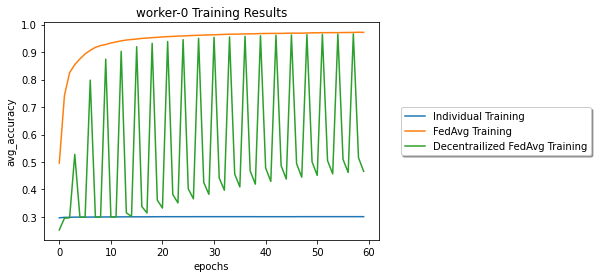

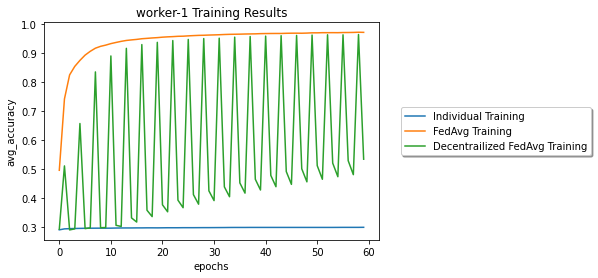

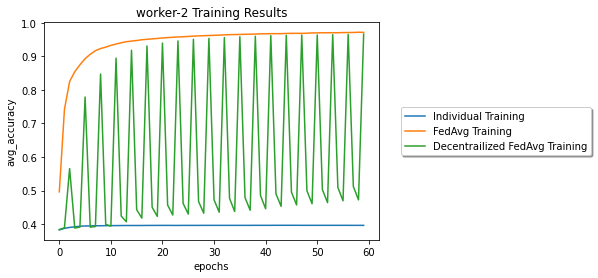

In [20]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()